In [2]:
import os
import xml.etree.ElementTree as ET
import logging
import sys
import time
import copy
import warnings
from functools import reduce
import datetime

import stanfordnlp
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import numpy as np
import torch as th

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import train_reviews_path, test_reviews_path, TEST_APPENDIX, word2vec_model_path, UNKNOWN_WORD, parsed_reviews_dump_path
from src.review import get_reviews, load_reviews, dump_reviews, reviews_dump_path
from src.preprocess.spell_check import spell_check, load_checked_reviews
from src.preprocess.dep_parse import parse_reviews, load_parsed_reviews, dump_parsed_reviews
from src.polarity.classifier import PolarityClassifier
from src.utils.embedding import get_embeddings

seed = 42
np.random.seed(seed)
th.manual_seed(seed)
th.cuda.manual_seed(seed)
logging.basicConfig(level=logging.INFO)

In [3]:
word2vec = get_embeddings()

INFO:gensim.models.utils_any2vec:loading projection weights from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin
INFO:gensim.models.utils_any2vec:loaded (249565, 300) matrix from /home/dmitry/Projects/diploma/research/RusVectores/tayga_upos_skipgram_300_2_2019/model.bin


In [4]:
# ___________________________Train_______________________________
train_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path)
train_sentences = [x for x in reduce(lambda x, y: x + y, train_reviews)]

INFO:root:Upload dependency trees from dump.


In [5]:
# ___________________________Test________________________________
test_reviews = load_parsed_reviews(file_pathway=parsed_reviews_dump_path + TEST_APPENDIX)
test_sentences = [x for x in reduce(lambda x, y: x + y, test_reviews)]

INFO:root:Upload dependency trees from dump.


/home/dmitry/Projects/diploma/research/.venv/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
INFO:root:Total parameters number: 26143
INFO:root:| Epoch 00000| Train accuracy: 0.75848597| Validation accuracy: 0.66923076| Time 4.4432 sec
INFO:root:| Epoch 00001| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.6619 sec
INFO:root:| Epoch 00002| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2949 sec
INFO:root:| Epoch 00003| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.3379 sec
INFO:root:| Epoch 00004| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2243 sec
INFO:root:| Epoch 00005| Train accuracy: 0.75897437| Validation accuracy: 0.66923076| Time 4.2637 sec
INFO:root:| Epoch 00006| Train

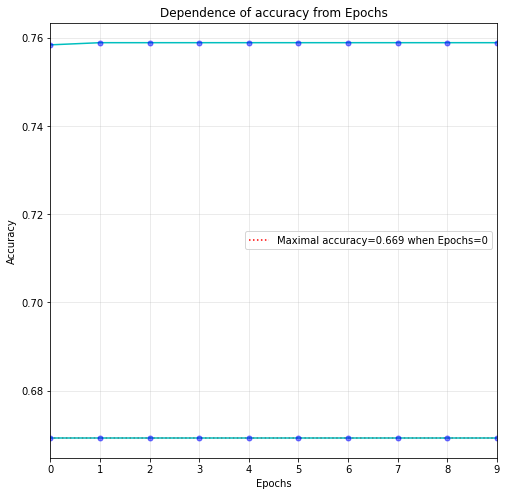

In [6]:
# preprocess_pipeline(word2vec=word2vec, is_train=True)
# preprocess_pipeline(word2vec=word2vec, is_train=False)

classifier = PolarityClassifier(word2vec=word2vec)
classifier.fit(train_sentences, test_sentences)

In [8]:
test_sentences_pred = copy.deepcopy(test_sentences)
test_sentences_pred = classifier.predict(test_sentences_pred)

In [ ]:
for sentence in test_sentences_pred[:10]:
    sentence.to_sentence().get_normalized().display()

In [ ]:
for sentence in test_sentences[:10]:
    sentence.to_sentence().get_normalized().display()